# PyTorch Workflow
6 Steps
1. Data (prepare and load)
2. Build model
3. Fitting model to data
4. Making predictions and eval (inference)
5. Saving and loading model
6. Putting it all together

In [108]:
import torch
from torch import nn # all of pytorch building blocks for a neural network
import matplotlib.pyplot as plt

torch.__version__

'2.1.2+cu121'

## 1. Data (prepare and load)

In [109]:
# create known parameters
weight = 0.9
bias = 0.2

# create 
start = 0
end = 1
step =0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.2000],
         [0.2180],
         [0.2360],
         [0.2540],
         [0.2720]]))

In [110]:
# Create train and test split
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

In [111]:
def plot_prediction(train_data=X_train,
                    train_label=y_train,
                    test_data=X_test,
                    test_label=y_test,
                    predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(5, 5))
    plt.scatter(train_data, train_label, c='b', s=4, label='Training data')
    plt.scatter(test_data, test_label, c='g', s=4, label='Testing data')

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')
    plt.legend(prop={'size':10})
    plt.show()

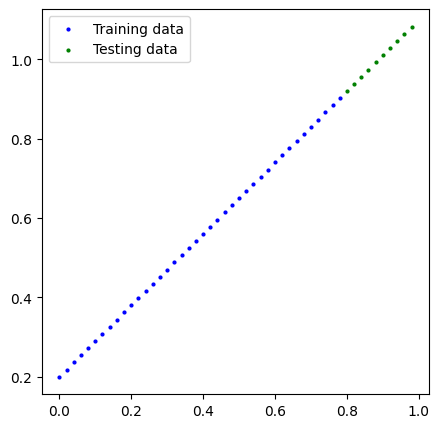

In [112]:
plot_prediction()

## 2. Build Model

Model Essentials
* Tensor
* torch.autograd
* torch.nn
* torch.nn.Module
* torchvision.models
* torch.nn.Parameter
* torch.nn.functional
* torch.optim
* torchmetrics
* torch.utils.tensorboard
* torch.manual_seed()
* def forward()
* model.state_dict()
* torch.inference_mode()

Data Essentials
* torchvision.transforms
* torch.utils.data.Dataset
* torch.utils.data.DataLoader

In [113]:
# Create linear regression model

class LinearRegressionModel(nn.Module): # we inherit nn.Module = base class for all models in PyTorch
    def __init__(self):
        super().__init__() # track grad with require_grad
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype = torch.float)) # not needed when copy from net
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype = torch.float)) # not needed when copy from net

        # Forward Method to define computation in model
    def forward(self, x:torch.Tensor) -> torch.Tensor: # Operation what model does
        return self.weights * x + self.bias # Linear regression model  

In [114]:
torch.manual_seed(42)
model = LinearRegressionModel()
model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [115]:
# to check model predicitive power with inference mode

with torch.inference_mode(): # Turns gradient tracking off (replacement for torch.no_grad)
    pred = model(X_test)
torch.hstack((pred, y_test))

tensor([[0.3982, 0.9200],
        [0.4049, 0.9380],
        [0.4116, 0.9560],
        [0.4184, 0.9740],
        [0.4251, 0.9920],
        [0.4318, 1.0100],
        [0.4386, 1.0280],
        [0.4453, 1.0460],
        [0.4520, 1.0640],
        [0.4588, 1.0820]])

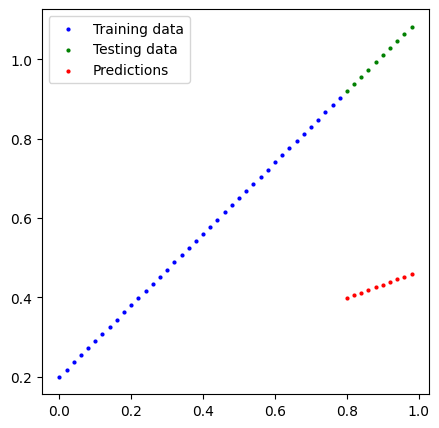

In [116]:
plot_prediction(predictions=pred)

## 3. Fitting Model to Data (Training) + 4. Making predictions and eval (inference)

### Loss functions(Cost Function, Criterion) used to measure how poorly a models preds are

* nn.X where X is L1Loss, MSELoss, CrossEntropyLoss, CTCLoss, NLLLoss, PoissonNLLLoss, KLDivLoss, BCELoss, BCEWithLogitsLoss, MarginRankingLoss, HingeEmbeddingLoss, MultiLabelMarginLoss, SmoothL1Loss, SoftMarginLoss, MultiLabelSoftMarginLoss, CosineEmbeddingLoss, MultiMarginLoss,
or TripletMarginLoss

### Optimizers used to adjust/update model parameters/weights based on loss
                                 
* optim.X where X is SGD, Adadelta, Adagrad, Adam, AdamW, SparseAdam, Adamax, ASGD, LBFGS, RMSprop or Rprop

Requirements
* Loss Function: Func to measure how wrong models preds are
* Optimizer: Takes loss into account and adjusts model params
* Training and Testing loop

In [117]:
loss_fn = nn.L1Loss() # Mean absolute Error
optimizer = torch.optim.SGD(params = model.parameters(), lr =0.01) # Stochastic Gradient Descent (lr = level of adjustment/step/changes of paramters per iteration)

### Building a training and testing Loop
1. Loop through data to do...
2. Forward Pass (Data going through function, also called forward propagation)
3. Caculate Loss (compare forward pass pred to GT)
4. Optimizer zero grad
5. Loss Backward (calc grad of each param of model wrt to loss, also called back propagation)
6. Optimizer Step (use optim to try to reduce loss)

In [118]:
torch.manual_seed(42)

epochs = 300 # num of times to pass over data (hyper param like lr)
print(f"Params before training {model.state_dict()}")

#Tracking Different values to compare diff params/models
epoch_count = []
train_loss_values = []
test_loss_values = []

#Training
for epoch in range(epochs):
    # set model to train mode
    model.train() # Sets all param that require grad to require grad
    # Forward pass
    pred = model(X_train)
    # Calculate Loss
    loss = loss_fn(pred, y_train)
    # optimizer zero grad
    optimizer.zero_grad() # by default optimizer changes will accumulate so we have to zero them with zero_grad
    # Back propagation on loss wrt param of model
    loss.backward()
    # Step the optimizer (Perform Gradient Descent on all with require_grads = True)
    optimizer.step()

    #Testing
    model.eval() # turns off different settings not needed for eval
    with torch.inference_mode(): # turns off grad tracking + few more (not needed for testing)
        # Forward pass
        test_pred = model(X_test)
        # Calculate Test Loss
        test_loss = loss_fn(test_pred, y_test)
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | MAE Train Loss: {loss}, MAE Test loss: {test_loss}")

print(f"Params after training {model.state_dict()}")

Params before training OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])
Epoch: 0 | MAE Train Loss: 0.29088133573532104, MAE Test loss: 0.5590652227401733
Epoch: 10 | MAE Train Loss: 0.17969869077205658, MAE Test loss: 0.4273907542228699
Epoch: 20 | MAE Train Loss: 0.1209946870803833, MAE Test loss: 0.33139681816101074
Epoch: 30 | MAE Train Loss: 0.09691917151212692, MAE Test loss: 0.26871782541275024
Epoch: 40 | MAE Train Loss: 0.08677728474140167, MAE Test loss: 0.22921133041381836
Epoch: 50 | MAE Train Loss: 0.08142194151878357, MAE Test loss: 0.20473821461200714
Epoch: 60 | MAE Train Loss: 0.07748124748468399, MAE Test loss: 0.18829430639743805
Epoch: 70 | MAE Train Loss: 0.07399125397205353, MAE Test loss: 0.17727422714233398
Epoch: 80 | MAE Train Loss: 0.07050124555826187, MAE Test loss: 0.1662541925907135
Epoch: 90 | MAE Train Loss: 0.06702403724193573, MAE Test loss: 0.15592096745967865
Epoch: 100 | MAE Train Loss: 0.06358523666858673, MAE Test loss: 0.14

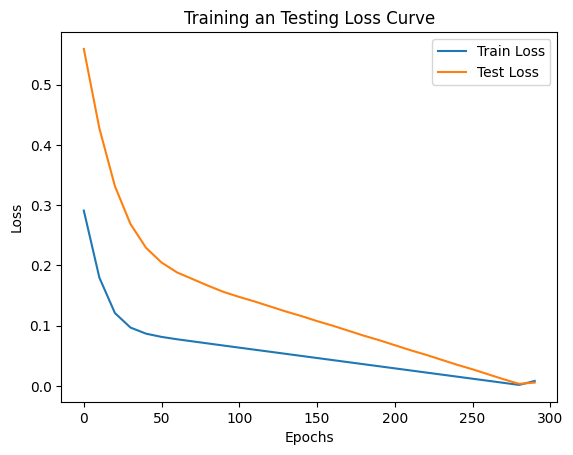

In [119]:
np_loss = torch.tensor(train_loss_values).numpy()
np_test_loss = torch.tensor(test_loss_values).numpy()
plt.plot(epoch_count, np_loss, label="Train Loss")
plt.plot(epoch_count, np_test_loss, label="Test Loss")
plt.title("Training an Testing Loss Curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [120]:
with torch.inference_mode():
    pred = model(X_test)
torch.hstack((pred, y_test))

tensor([[0.9279, 0.9200],
        [0.9459, 0.9380],
        [0.9639, 0.9560],
        [0.9818, 0.9740],
        [0.9998, 0.9920],
        [1.0178, 1.0100],
        [1.0358, 1.0280],
        [1.0538, 1.0460],
        [1.0717, 1.0640],
        [1.0897, 1.0820]])

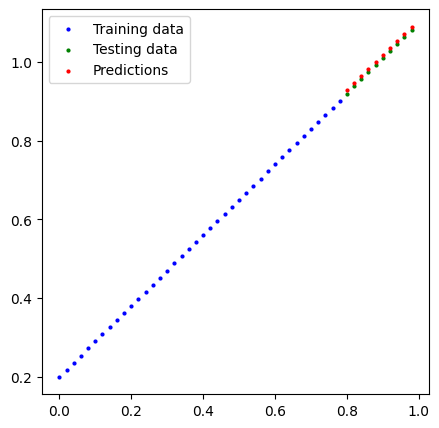

In [121]:
plot_prediction(predictions=pred)

## 5. Saving Model in PyTorch
1. 'torch.save()' allow to save a PyTorch model in pickle format
2. 'torch.load()' allow to load a save PyTorch object
3. 'torch.nn.Module.load_state_dict()' load a models saved state dict (params)

In [122]:
# Saving our PyTorch Model
from pathlib import Path

# 1. Create model dir
MODEL_PATH = Path("intro_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "2_pytorch_workflow_model_0.pth" # pt or pth file extension
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict (dict of weights and params)
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: intro_models\2_pytorch_workflow_model_0.pth


In [123]:
# Loading our PyTorch Model
load_model = LinearRegressionModel()
load_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [124]:
# Making some predictions to check same weights or not
load_model.eval()
with torch.inference_mode():
    load_model_pred = load_model(X_test)
torch.hstack((load_model_pred, pred))

tensor([[0.9279, 0.9279],
        [0.9459, 0.9459],
        [0.9639, 0.9639],
        [0.9818, 0.9818],
        [0.9998, 0.9998],
        [1.0178, 1.0178],
        [1.0358, 1.0358],
        [1.0538, 1.0538],
        [1.0717, 1.0717],
        [1.0897, 1.0897]])

## 6. Putting it all together

In [125]:
# Putting it all back together
import torch
from torch import nn
import matplotlib.pyplot as plt 
from pathlib import Path

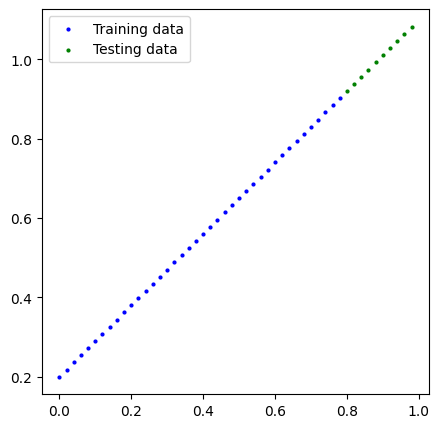

Epoch: 0 | MAE Train Loss: 0.5564687252044678, MAE Test loss: 0.5689631104469299
Epoch: 10 | MAE Train Loss: 0.4396587014198303, MAE Test loss: 0.4357529878616333
Epoch: 20 | MAE Train Loss: 0.32284867763519287, MAE Test loss: 0.30254286527633667
Epoch: 30 | MAE Train Loss: 0.2060386836528778, MAE Test loss: 0.16933278739452362
Epoch: 40 | MAE Train Loss: 0.08922868967056274, MAE Test loss: 0.036122679710388184
Epoch: 50 | MAE Train Loss: 0.02032984420657158, MAE Test loss: 0.043520912528038025
Epoch: 60 | MAE Train Loss: 0.01788131520152092, MAE Test loss: 0.041480302810668945
Epoch: 70 | MAE Train Loss: 0.015701737254858017, MAE Test loss: 0.036896467208862305
Epoch: 80 | MAE Train Loss: 0.013522160239517689, MAE Test loss: 0.032312631607055664
Epoch: 90 | MAE Train Loss: 0.011346532963216305, MAE Test loss: 0.02689117193222046
Epoch: 100 | MAE Train Loss: 0.009170906618237495, MAE Test loss: 0.021469689905643463
Epoch: 110 | MAE Train Loss: 0.006995281204581261, MAE Test loss: 0.016

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

In [137]:
device = "cuda" if torch.cuda.is_available else "cpu" # device agnostic code for model

X = torch.arange(start=0.1,end=0.9, step=0.02).unsqueeze(dim=1)
y = 0.7 * X + 0.3

# device agnostic code for data
train_split = int(len(X)* 0.8)
X_train, y_train = X[:train_split].to(device), y[:train_split].to(device)
X_test, y_test = X[train_split:].to(device), y[train_split:].to(device)

plot_prediction()

class LinearRegres(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(42)

model_self = LinearRegres()
model_self.to(device)

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_self.parameters(), lr=0.01)

epochs = 200

for epoch in range(epochs):
    model_self.train()
    pred = model_self(X_train) # forward pass 
    loss = loss_fn(pred, y_train) # calculate loss
    optimizer.zero_grad() # set grads to zero so no accumulation of grad
    loss.backward() # backward prop
    optimizer.step() # update parameters

    model_self.eval()
    with torch.inference_mode():
        test_pred = model_self(X_test)
        test_loss = loss_fn(test_pred, y_test)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | MAE Train Loss: {loss}, MAE Test loss: {test_loss}")

model_self.eval()
with torch.inference_mode():
     y_preds = model_self(X_test)

MODEL_PATH = Path("intro_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "2_pytorch_workflow_model_0.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_self.state_dict(), f=MODEL_SAVE_PATH)

loaded_model_self = LinearRegres()
loaded_model_self.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model_self.to(device)

next(loaded_model_self.parameters()).device
print(loaded_model_self.state_dict())

loaded_model_self.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_self(X_test)
y_preds == loaded_model_preds
